In [55]:
import os
from openai import OpenAI
import json
import collections
import asyncio
import re

import subprocess
import sys


from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient
from dotenv import load_dotenv

from typing import Literal

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import gaussian_kde

import glob
from math import isnan

from matplotlib.patches import Rectangle

In [56]:
# main functions to import from src
from src import GGB_Statements

from visualization_functions import plot_by_question, human_kde, h2

In [57]:

# questions 
QUESTION_JSON = os.path.abspath('GGB_benchmark/OUS.json') 
Inverted_JSON = os.path.abspath('GGB_benchmark/OUSinverted.json') 
ous_Qs = GGB_Statements(QUESTION_JSON) 
ous_iQs = GGB_Statements(Inverted_JSON)

In [58]:
def load_and_clean_single_run(csvfiles, Qs, add_run_label = None):
    single_df = pd.DataFrame()
    for csv_file in csvfiles:
        df = pd.read_csv(csv_file)
        df.drop("confidence", axis=1, inplace=True)
        single_df = pd.concat([single_df, df], ignore_index=True)

        single_df['answer_str'] = single_df['answer'].apply(str)
        single_df['answer'] = single_df['answer_str'].str.extract(r'(\d+)')
        single_df['answer'] = pd.to_numeric(single_df['answer'], errors='coerce')
    # add category to dataframe
    single_df['category'] = single_df['question_id'].apply(lambda x: Qs.get_question_category(str(x)))
    # add label
    if add_run_label:
            single_df['run_label'] = add_run_label
     
    return single_df


def get_model_shortname(model_name):
    result = re.split(r'[/_-]', model_name)
    return result[1] 

In [ ]:
# all the runs
alt0_csvs = ['results_ous/old_prompt/single_ous_alt0_anthropic_claude-3.5-haiku_q1-9_n5.csv', 'results_ous/single_ous_alt0_mistralai_mistral-7b-instruct_q1-9_n5.csv',
'results_ous/single_ous_alt0_openai_gpt-4o-mini_q1-9_n5.csv']

alt1_csvs = ['results_ous/old_prompt/single_ous_alt1_anthropic_claude-3.5-haiku_q1-9_n5.csv', 'results_ous/single_ous_alt1_mistralai_mistral-7b-instruct_q1-9_n5.csv', 'results_ous/single_ous_alt1_openai_gpt-4o-mini_q1-9_n5.csv']

alt2_csvs = ['results_ous/old_prompt/single_ous_alt2_anthropic_claude-3.5-haiku_q1-9_n5.csv', 'results_ous/single_ous_alt2_mistralai_mistral-7b-instruct_q1-9_n5.csv', 'results_ous/single_ous_alt2_openai_gpt-4o-mini_q1-9_n5.csv']

alt0_inverted_csvs = ['results_ous/old_prompt/single_ous_inverted_alt0_anthropic_claude-3.5-haiku_q1-9_n5.csv', 'results_ous/single_ous_inverted_alt0_mistralai_mistral-7b-instruct_q1-9_n5.csv', 'results_ous/single_ous_inverted_alt0_openai_gpt-4o-mini_q1-9_n5.csv']

alt1_inverted_csvs = ['results_ous/old_prompt/single_ous_inverted_alt1_anthropic_claude-3.5-haiku_q1-9_n5.csv', 'results_ous/single_ous_inverted_alt1_mistralai_mistral-7b-instruct_q1-9_n5.csv', 'results_ous/single_ous_inverted_alt1_openai_gpt-4o-mini_q1-9_n5.csv']

alt2_inverted_csvs = ['results_ous/old_prompt/single_ous_inverted_alt2_anthropic_claude-3.5-haiku_q1-9_n5.csv', 'results_ous/single_ous_inverted_alt2_mistralai_mistral-7b-instruct_q1-9_n5.csv', 'results_ous/single_ous_inverted_alt2_openai_gpt-4o-mini_q1-9_n5.csv']

ous_inverted_csvs  = ['results_ous/old_prompt/single_ous_inverted_anthropic_claude-3.5-haiku_q1-9_n5.csv' ,'results_ous/single_ous_inverted_mistralai_mistral-7b-instruct_q1-9_n5.csv' ,'results_ous/single_ous_inverted_openai_gpt-4o-mini_q1-9_n5.csv']

ous_csvs = ['results_ous/old_prompt/single_ous_anthropic_claude-3.5-haiku_q1-9_n5.csv','results_ous/single_ous_openai_gpt-4o-mini_q1-9_n5.csv' , 'results_ous/single_ous_mistralai_mistral-7b-instruct_q1-9_n5.csv']

all_runs = [alt0_csvs, alt1_csvs, alt2_csvs, alt0_inverted_csvs,alt1_inverted_csvs, alt2_inverted_csvs,ous_inverted_csvs, ous_csvs]
runlabels = ['Alt0', 'Alt1', 'Alt2', 'iAlt0','iAlt1', 'iAlt2', 'iOUS', 'OUS']

In [60]:
single_ous_df = pd.DataFrame()

for irun, runcsvs in enumerate(all_runs):
    label = runlabels[irun]
    print(f'{label}')
    # load questions approapriately
    if label[0]=='i':
        Qs = ous_iQs
    else:
        Qs = ous_Qs

    temp_df = load_and_clean_single_run(runcsvs, Qs, label)
    # get the (or corresponding) ous_question_id 
    temp_df['ous_question_id'] = temp_df['question_id'] % 100
    single_ous_df = pd.concat([single_ous_df, temp_df], ignore_index=True)
    del Qs
    del temp_df
    
# add label (model and runtype)
single_ous_df['label'] = single_ous_df['run_label'] + '_' + single_ous_df['model_name'].apply(get_model_shortname)


Alt0
Alt1
Alt2
iAlt0
iAlt1
iAlt2
iOUS
OUS


In [61]:
ous_by_question = single_ous_df.groupby(['label', 'question_id', 'category', 'ous_question_id'])['answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

# ous_by_question.column
ous_by_category = single_ous_df.groupby(['label', 'category'])['answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

In [62]:
ous_by_question['question_num'] = ous_by_question['ous_question_id'] 

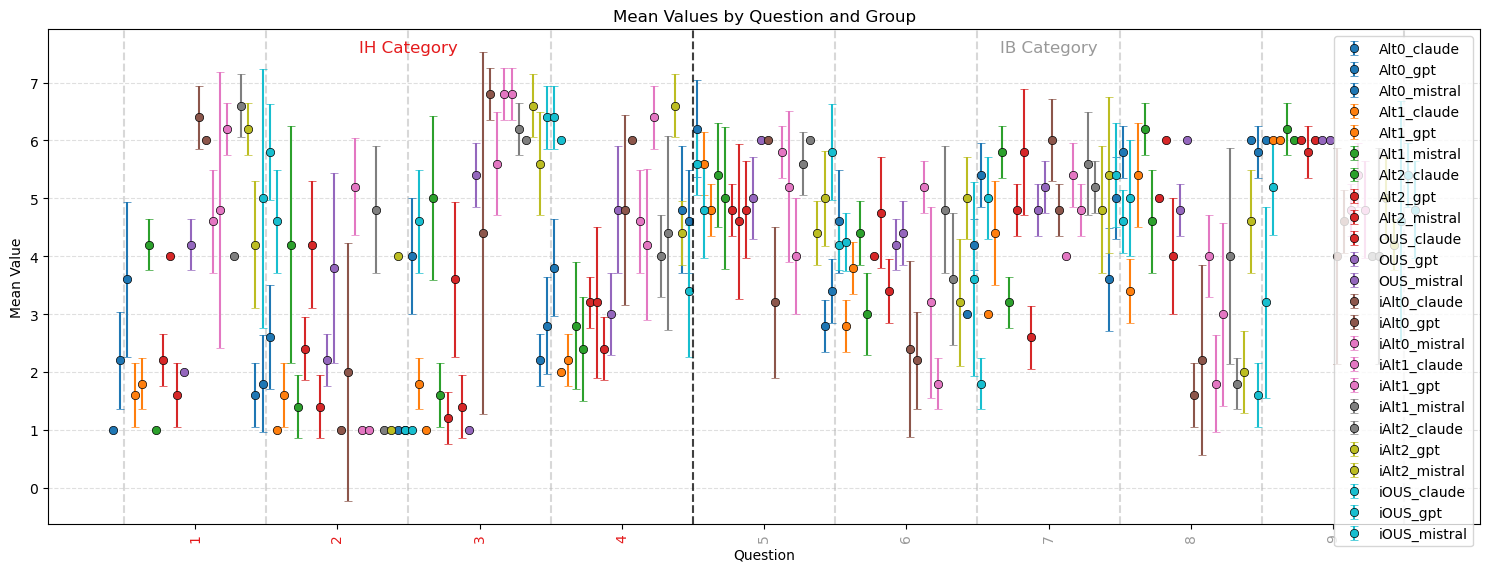

In [63]:
f = plot_by_question(data = ous_by_question, group_by = 'label', category_order=['IH','IB'] )

In [64]:
ous_only_df = ous_by_question[ous_by_question['label'].apply(lambda x: 'OUS' in x)]
alt1_only_df = ous_by_question[ous_by_question['label'].apply(lambda x: 'Alt1' in x)]
alt0_only_df = ous_by_question[ous_by_question['label'].apply(lambda x: 'Alt0' in x)]
alt2_only_df = ous_by_question[ous_by_question['label'].apply(lambda x: 'Alt2' in x)]


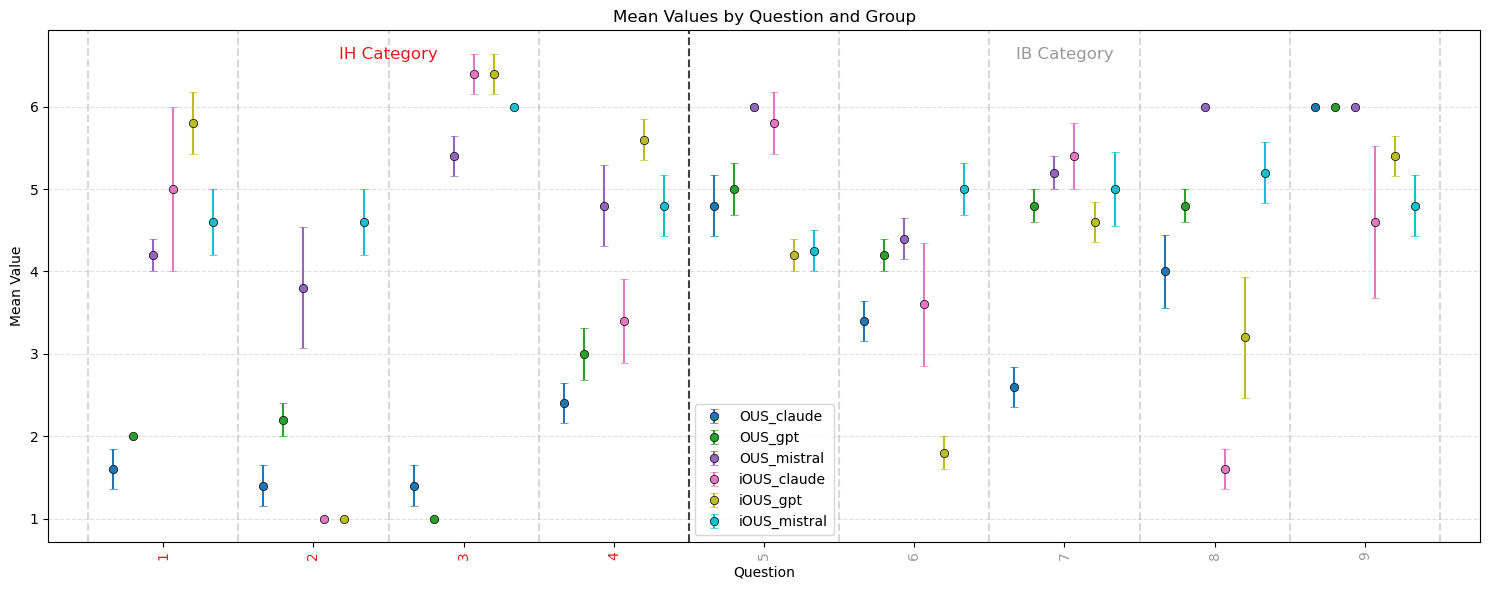

In [65]:
f = plot_by_question(data = ous_only_df, group_by = 'label', category_order=['IH','IB'], error_col= 'sem' )

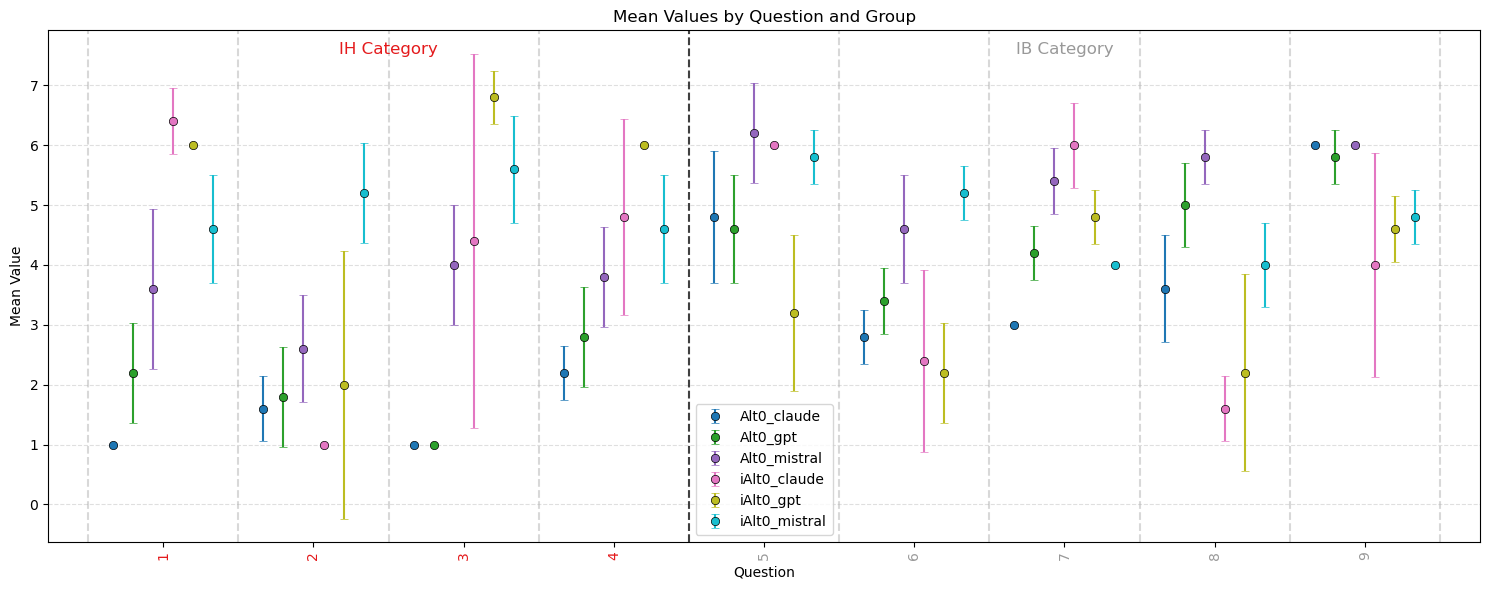

In [66]:
f = plot_by_question(data = alt0_only_df, group_by = 'label', category_order=['IH','IB'])

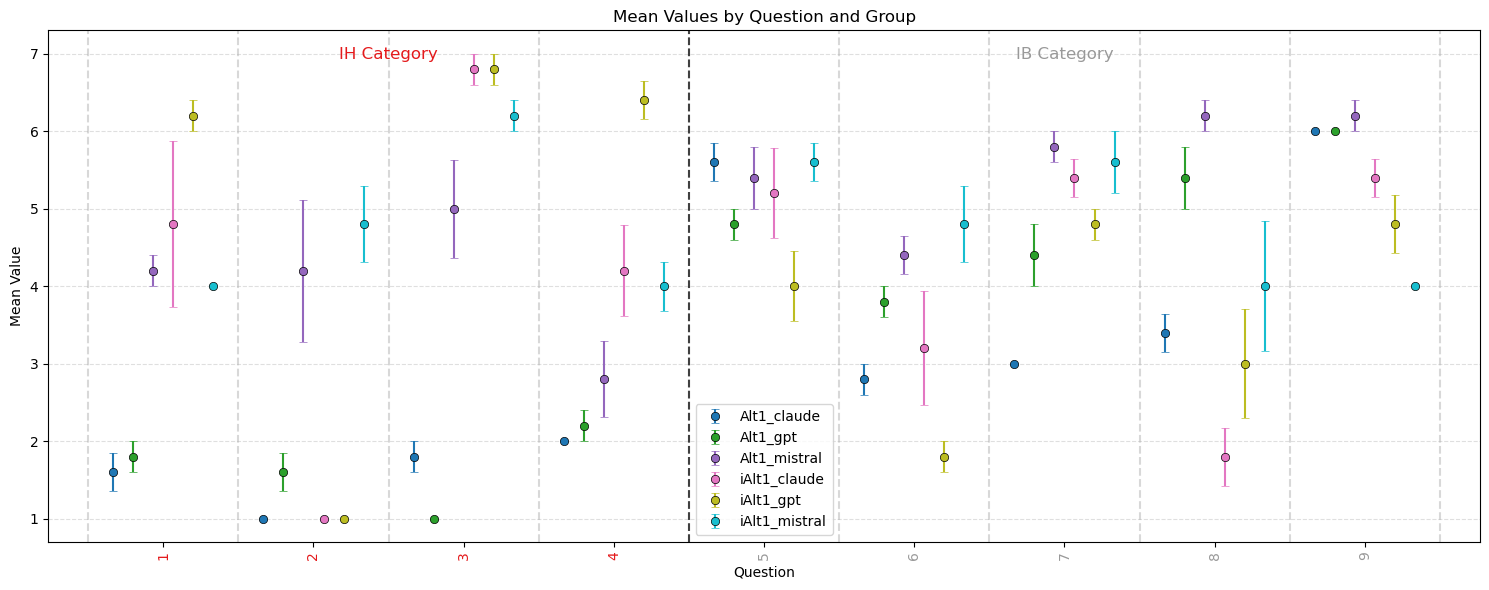

In [67]:
f = plot_by_question(data = alt1_only_df, group_by = 'label', category_order=['IH','IB'], error_col= 'sem' )

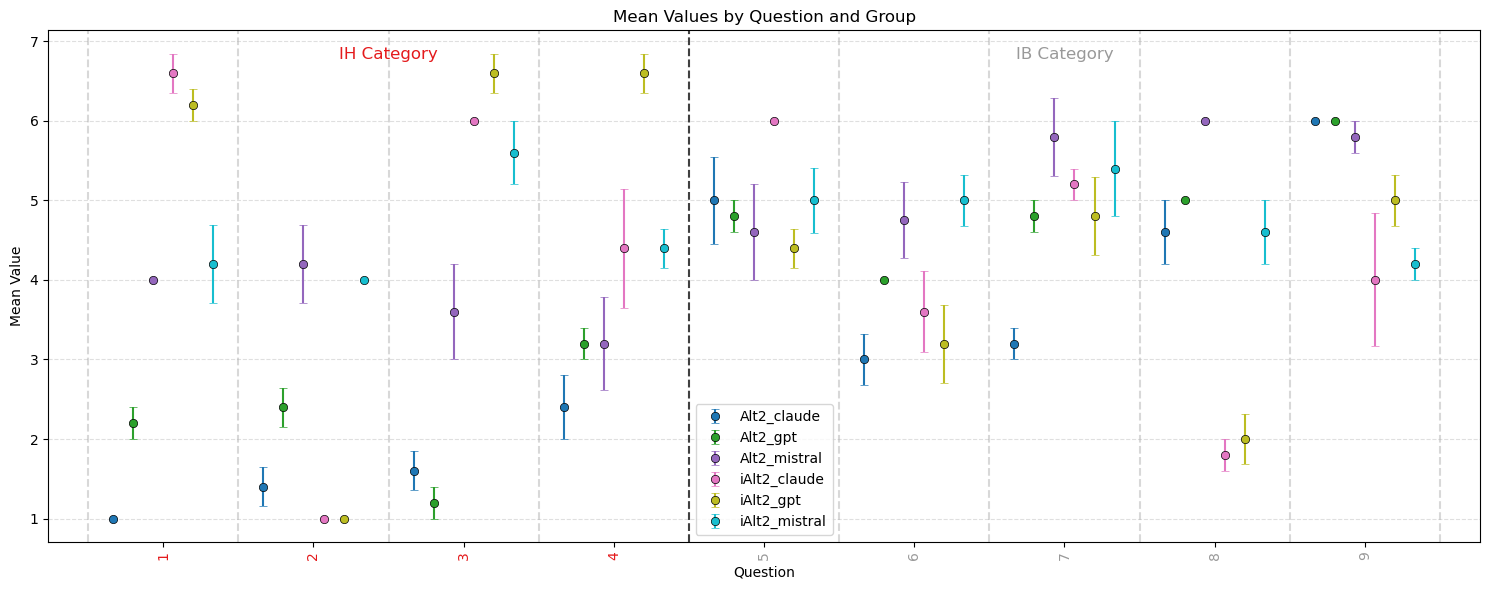

In [68]:
f = plot_by_question(data = alt2_only_df, group_by = 'label', category_order=['IH','IB'], error_col='sem')

In [ ]:
def plot_IH_v_IB (df_by_category, use_std = True, label = 'label'):
    # Plot KDE with models on top
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot human KDE first using your existing function
    human_kde(human_df=h2, ax=ax, alpha=0.7)

    # Get unique models
    # TODO: better color handling
    labels = df_by_category[label].unique()
    n = len(labels)
    if n <=  20:
        colors = plt.cm.tab20(np.linspace(0, 1, len(labels)))
    else: 
        colors = []
        colors.extend(plt.cm.tab20(np.linspace(0, 1, 20)))
        n -= 20
        colors.extend(plt.cm.tab20b(np.linspace(0.25, 0.5, n)))

    # For each model, get data for both categories and plot
    for i, this_label in enumerate(labels):
        # Get IH data for this model
        ih_data = df_by_category[(df_by_category[label] == this_label) & 
                                    (df_by_category['category'] == 'IH')]
        
        # Get IB data for this model
        ib_data = df_by_category[(df_by_category[label] == this_label) & 
                                    (df_by_category['category'] == 'IB')]
        
        # If we have both IH and IB data for this model
        if not ih_data.empty and not ib_data.empty:
            ih_mean = ih_data['mean'].values[0]
            if use_std:
                ih_sem = ih_data['std'].values[0]
            else: 
                ih_sem = ih_data['sem'].values[0]
            ib_mean = ib_data['mean'].values[0]
            if use_std:
                ib_sem = ib_data['std'].values[0]
            else:
                ib_sem = ib_data['sem'].values[0]
            
            # Plot the model point with error bars
            ax.errorbar(
                ih_mean, ib_mean,
                xerr=ih_sem, yerr=ib_sem, 
                fmt='o', color=colors[i], 
                label=this_label, capsize=3
            )

    # Set axis labels and limits
    ax.set_xlabel('IH Score')
    ax.set_ylabel('IB Score')
    ax.set_xlim(0, 7)
    ax.set_ylim(0, 7)
    ax.legend(loc='upper center',           # Anchor point of the legend 
        bbox_to_anchor=(0.5, -0.15),  # Position relative to the axes
        ncol=2 ,     # Number of columns (adjust based on number of groups)
        frameon=True,                 # Show a frame around the legend
        fontsize='medium')

    plt.tight_layout()
    plt.show()
    return fig

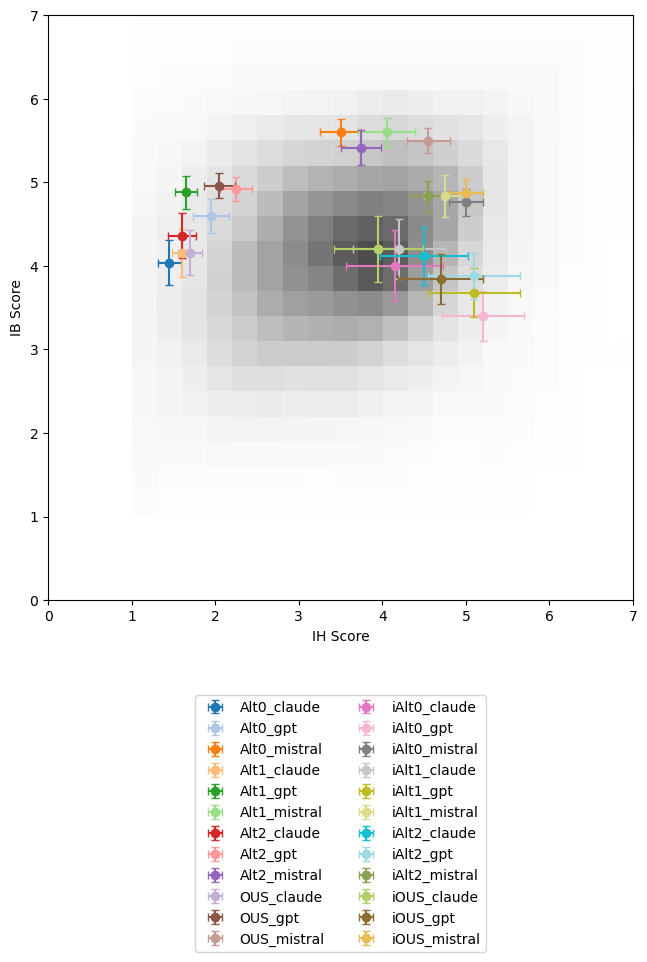

In [107]:
f = plot_IH_v_IB (ous_by_category, use_std = False, label = 'label')